In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, LSTM, Flatten, TimeDistributed
import joblib

In [4]:
# === 2. LOAD DATA ===
df = pd.read_excel("rumah_tangga.xlsx")

In [5]:
# === 3. PREPROCESSING ===
df.dropna(inplace=True)
df = df[df['Jenis Kelamin'] == 'Perempuan']

In [6]:
# One-hot encoding
df = pd.get_dummies(df, columns=['Daerah', 'Kelompok Umur'])

In [7]:
# Tentukan kolom target
target_cols = ['Belum Kawin', 'Kawin', 'Cerai Hidup', 'Cerai Mati']
feature_cols = [col for col in df.columns if col not in target_cols + ['Tahun', 'Jenis Kelamin']]

In [8]:
# Scaling
scaler = MinMaxScaler()
df[target_cols] = scaler.fit_transform(df[target_cols])
joblib.dump(scaler, 'scaler.save')  # simpan untuk web app

['scaler.save']

In [9]:
import joblib

scaler = MinMaxScaler()
df[target_cols] = scaler.fit_transform(df[target_cols])

# Simpan scaler
joblib.dump(scaler, "scaler.save")


['scaler.save']

In [10]:
# === 4. TIME SERIES DATASET ===
def create_dataset(X, y, time_steps=5):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X = df[feature_cols].values
y = df[target_cols].values
X_ts, y_ts = create_dataset(X, y, time_steps=5)

In [11]:
# Pastikan semua array bertipe float32
X_ts = X_ts.astype(np.float32)
y_ts = y_ts.astype(np.float32)


In [12]:
# Split train-test
X_train, X_test, y_train, y_test = train_test_split(X_ts, y_ts, test_size=0.2, shuffle=False)

In [13]:
# === 5. MODEL CNN ===
model_cnn = Sequential()
model_cnn.add(Conv1D(64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_cnn.add(Dropout(0.2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(y_train.shape[1]))
model_cnn.compile(optimizer='adam', loss='mse')

model_cnn.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1)
y_pred_cnn = model_cnn.predict(X_test)
mse_cnn = mean_squared_error(y_test, y_pred_cnn)
print("CNN MSE:", mse_cnn)

c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - loss: 119.6714 - val_loss: 102.3711
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 41.6742 - val_loss: 43.0321
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 17.6776 - val_loss: 8.2856
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 15.9403 - val_loss: 6.2009
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 9.4279 - val_loss: 5.2914
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 13.9429 - val_loss: 11.8976
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 9.0972 - val_loss: 8.1108
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 6.9225 - val_loss: 6.6627
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 8.5598 - val_loss: 1.3862
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 6.4705 - val_loss: 2.0737
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 5.8521 - val_loss: 2.4204
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 5.3551 - val_los

In [14]:
# === 6. MODEL LSTM ===
model_lstm = Sequential()
model_lstm.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(50, activation='relu'))
model_lstm.add(Dense(y_train.shape[1]))
model_lstm.compile(optimizer='adam', loss='mse')

model_lstm.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1)
y_pred_lstm = model_lstm.predict(X_test)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
print("LSTM MSE:", mse_lstm)

model_lstm.save("model_lstm.h5")

c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 508ms/step - loss: 38.1793 - val_loss: 35.5533
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 9.9374 - val_loss: 4.4352
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 3.3675 - val_loss: 0.7847
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 1.5758 - val_loss: 1.6662
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.2060 - val_loss: 0.9591
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.9049 - val_loss: 0.4600
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.5628 - val_loss: 0.3813
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.4865 - val_loss: 0.3421
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 0.4467 - val_loss: 0.1409
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.3248 - val_loss: 0.1194
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.4049 - val_loss: 0.1626
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.2870 - val_loss: 0.

LSTM MSE: 0.15303774178028107


In [15]:
# === SETUP CNN-LSTM ===
n_seq = 5
n_steps = 1
n_features = X.shape[1]

total_samples = (X.shape[0] // (n_seq * n_steps)) * (n_seq * n_steps)
X_cut = X[:total_samples].astype('float32')
y_cut = y[:total_samples // (n_seq * n_steps)].astype('float32')

X_cl = X_cut.reshape((-1, n_seq, n_steps, n_features))

from sklearn.model_selection import train_test_split
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X_cl, y_cut, test_size=0.2, shuffle=False)




In [16]:
# === CNN-LSTM MODEL ===
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv1D, Flatten, LSTM, Dense

model_cnnlstm = Sequential()
model_cnnlstm.add(TimeDistributed(Conv1D(64, 1, activation='relu'), input_shape=(n_seq, n_steps, n_features)))
model_cnnlstm.add(TimeDistributed(Flatten()))
model_cnnlstm.add(LSTM(50, activation='relu'))
model_cnnlstm.add(Dense(y.shape[1]))
model_cnnlstm.compile(optimizer='adam', loss='mse')

model_cnnlstm.fit(X_train_cl, y_train_cl, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - loss: 1.2941 - val_loss: 0.1482
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 477ms/step - loss: 0.1640 - val_loss: 0.1642
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.1503 - val_loss: 0.2411
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - loss: 0.1683 - val_loss: 0.1857
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - loss: 0.1543 - val_loss: 0.1719
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - loss: 0.1411 - val_loss: 0.1898
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step - loss: 0.1458 - val_loss: 0.1934
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - loss: 0.1366 - val_loss: 0.1906
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step - loss: 0.1334 - val_loss: 0.1775
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 0.1304 - val_loss: 0.1642
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.1246 - val_loss: 0.1590
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.1201 - val_loss

In [17]:
# Setelah training model_cnnlstm
y_pred_cnnlstm = model_cnnlstm.predict(X_test_cl)

# Evaluasi MSE CNN-LSTM
from sklearn.metrics import mean_squared_error
mse_cnnlstm = mean_squared_error(y_test_cl, y_pred_cnnlstm)
print("CNN-LSTM MSE:", mse_cnnlstm)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
CNN-LSTM MSE: 0.22089360654354095


In [18]:
# === 8. INVERSE TRANSFORM HASIL ===
scaler = joblib.load('scaler.save')
y_pred_lstm_original = scaler.inverse_transform(y_pred_lstm)
y_test_original = scaler.inverse_transform(y_test)

In [19]:
# === 10. VISUALISASI GRAFIK HASIL PREDIKSI vs DATA ASLI ===

import matplotlib.pyplot as plt

def plot_prediction(y_true, y_pred, model_name, label_names):
    y_true_inv = scaler.inverse_transform(y_true)
    y_pred_inv = scaler.inverse_transform(y_pred)
    
    plt.figure(figsize=(12, 8))
    for i in range(y_true.shape[1]):
        plt.subplot(2, 2, i+1)
        plt.plot(y_true_inv[:, i], label='Actual', color='blue')
        plt.plot(y_pred_inv[:, i], label='Predicted', color='orange')
        plt.title(f'{label_names[i]} - {model_name}')
        plt.xlabel('Sample')
        plt.ylabel('Jumlah')
        plt.legend()
    plt.tight_layout()
    plt.show()


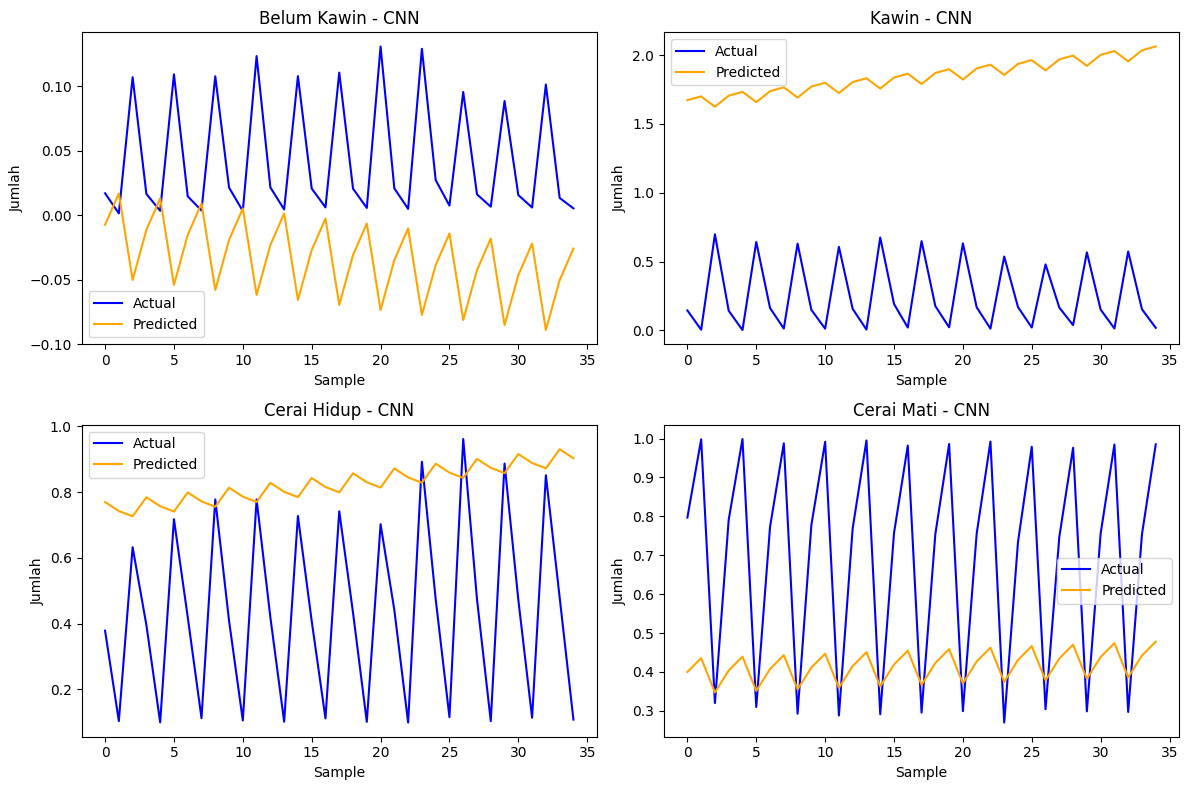

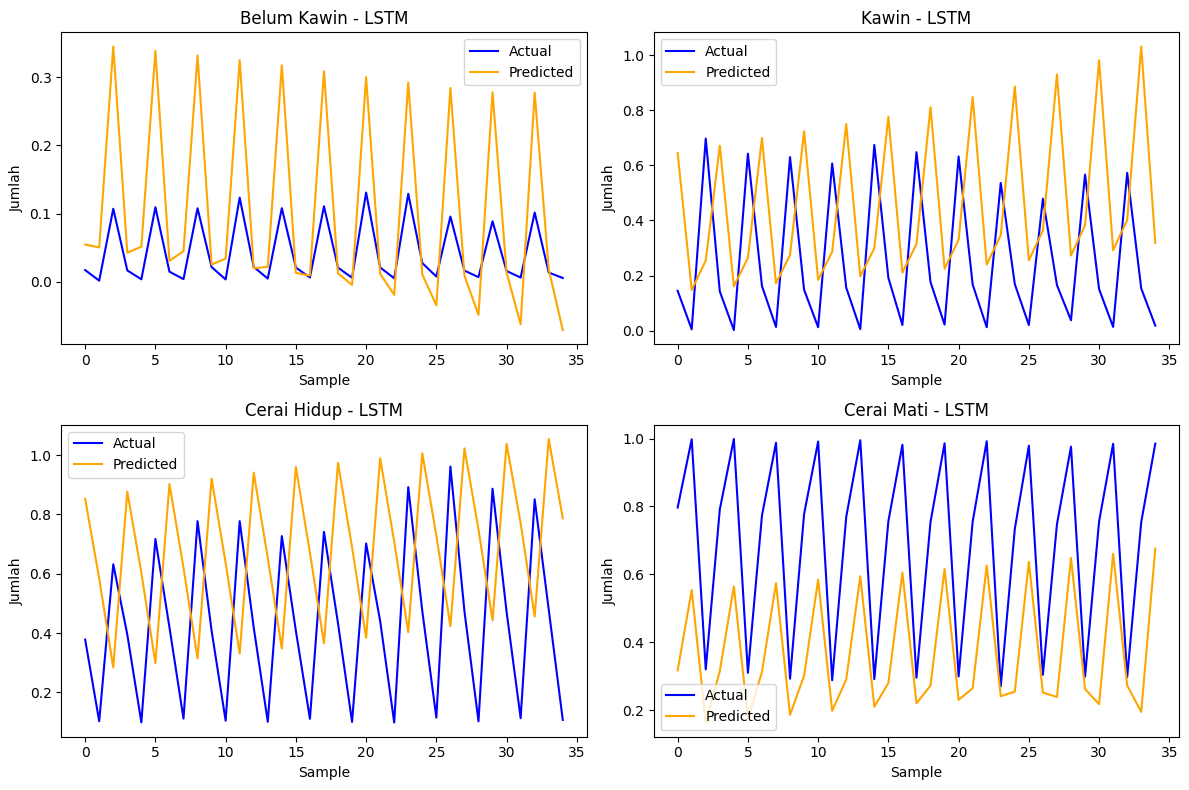

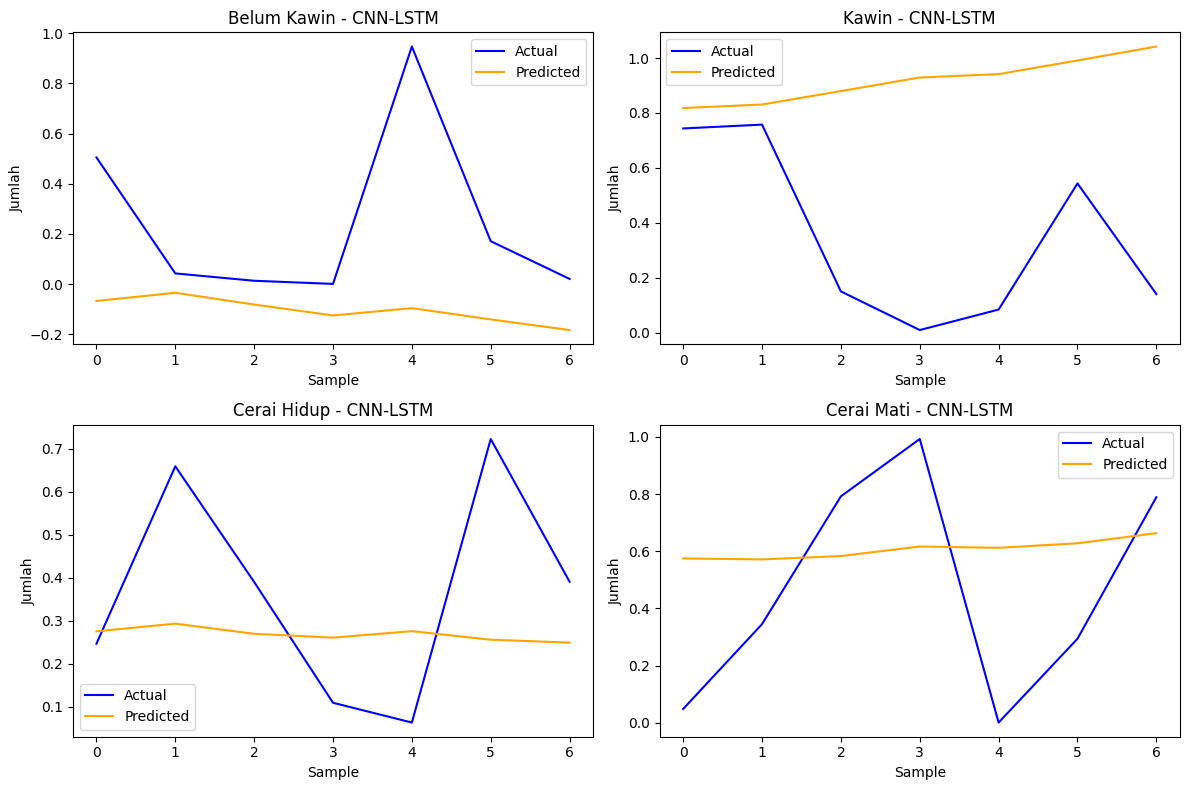

In [20]:
# === Evaluasi Visual CNN ===
plot_prediction(y_test, y_pred_cnn, "CNN", target_cols)

# === Evaluasi Visual LSTM ===
plot_prediction(y_test, y_pred_lstm, "LSTM", target_cols)

# === Evaluasi Visual CNN-LSTM ===
plot_prediction(y_test_cl, y_pred_cnnlstm, "CNN-LSTM", target_cols)


In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_regression_per_label(y_true, y_pred, label_names, model_name="Model"):
    print(f"\n=== Evaluasi Regresi: {model_name} ===\n")
    
    results = []
    for i, label in enumerate(label_names):
        mse = mean_squared_error(y_true[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
        r2 = r2_score(y_true[:, i], y_pred[:, i])
        results.append([label, mse, rmse, mae, r2])
    
    # Tampilkan tabel evaluasi
    df_result = pd.DataFrame(results, columns=["Label", "MSE", "RMSE", "MAE", "R²"])
    print(df_result)

    # === VISUALISASI SCATTER PREDIKSI vs AKTUAL ===
    plt.figure(figsize=(12, 8))
    for i, label in enumerate(label_names):
        plt.subplot(2, 2, i+1)
        plt.scatter(y_true[:, i], y_pred[:, i], alpha=0.7)
        plt.plot([min(y_true[:, i]), max(y_true[:, i])],
                 [min(y_true[:, i]), max(y_true[:, i])], 'r--')
        plt.xlabel("Aktual")
        plt.ylabel("Prediksi")
        plt.title(f"{label} - {model_name}")
    plt.tight_layout()
    plt.show()

    # === HEATMAP KORELASI PREDIKSI vs AKTUAL ===
    df_corr = pd.DataFrame()
    for i, label in enumerate(label_names):
        df_corr[f"Aktual {label}"] = y_true[:, i]
        df_corr[f"Prediksi {label}"] = y_pred[:, i]

    plt.figure(figsize=(10, 8))
    sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm')
    plt.title(f"Korelasi Prediksi vs Aktual - {model_name}")
    plt.show()
